# Natural Language Processing - Unsupervised Topic Modeling with Reddit Posts

###### This project dives into multiple techniques used for NLP and subtopics such as dimensionality reduction, topic modeling, and clustering.

1. [Google BigQuery](#Google-BigQuery)
1. [Exploratory Data Analysis (EDA) & Preprocessing](#Exploratory-Data-Analysis-&-Preprocessing)
1. [Singular Value Decomposition (SVD)](#Singular-Value-Decomposition-(SVD))
1. [Latent Semantic Analysis (LSA - applied SVD)](#Latent-Semantic-Analysis-(LSA))
1. [Similarity Scoring Metrics](#sim)
1. [KMeans Clustering](#km)
1. [Latent Dirichlet Allocation (LDA)](#lda)
1. [pyLDAvis - interactive d3 for LDA](#py)
 - This was separated out in a new notebook to quickly view visual (load files and see visualization)

In [116]:
# Easter Egg to start your imports
#import this 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging
import pickle
import sys
import os
import pickle
from gensim import models

from google.cloud import bigquery

In [117]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Logging is the verbose for Gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#plt.style.available # Style options
plt.style.use('fivethirtyeight')
sns.set_context("talk")
%matplotlib inline

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
pd.options.display.max_colwidth = 99
#pd.describe_option('display') # Option settings

float_formatter = lambda x: "%.3f" % x if x>0 else "%.0f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)

## Google BigQuery

In [118]:
%%time

# path = os.getcwd()+"data/posts5000.pkl"
path = "data/posts5000.pkl"
df = pd.read_pickle(path)
df.info(memory_usage='Deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   created_utc   5000 non-null   float64
 1   subreddit     5000 non-null   object 
 2   author        4999 non-null   object 
 3   domain        5000 non-null   object 
 4   url           5000 non-null   object 
 5   num_comments  5000 non-null   int64  
 6   score         5000 non-null   int64  
 7   title         5000 non-null   object 
 8   selftext      5000 non-null   object 
 9   id            5000 non-null   object 
 10  gilded        5000 non-null   int64  
 11  over_18       5000 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 434.7+ KB
CPU times: total: 1.28 s
Wall time: 3.47 s


## Exploratory Data Analysis & Preprocessing

In [119]:
# Exploring data by length of .title or .selftext
df[[ True if 500 < len(x) < 800 else False for x in df.selftext ]].sample(3, replace=False)
# df[[ True if 500 < len(x) < 800 else False for x in df.selftext ]]

,created_utc,subreddit,author,domain,url,num_comments,score,title,selftext,id,gilded,over_18
2737,1684800857.000,Supernatural,tamsinred,reddit.com,https://www.reddit.com/gallery/13p87w8,37,344,The Golem,Name a bigger badass than the Golem. Who took on an entire freaking magical death camp AND WON....,13p87w8,0,False
2978,1684783963.000,90dayfianceuncensored,Good_At_Wine,self.90dayfianceuncensored,https://www.reddit.com/r/90dayfianceuncensored/comments/13p0oy7/i_cant_take_the_bullying_of_ris...,215,735,I can't take the bullying of Rishi. It's so ignorant and foul and racist.,Are you telling me nobody on this entire panel has the brain power to understand that Rishi liv...,13p0oy7,0,False
2524,1684795445.000,OldSchoolCool,OkImprovement90,i.redd.it,https://i.redd.it/bydd731v5i1b1.jpg,96,2370,"Known as 'The Incubator Doctor', Martin Couney was responsible for saving over 7,000 prematurel...","He achieved this by showcasing these infants in incubators at his Coney Island exhibition, char...",13p5zs4,0,False


In [120]:
%%time
run = False
path = '/home/User/data/gif'

# Run through various selftext lengths and save the plots of the distribution of the metric
# Gif visual after piecing all the frames together
while run==True:
    for i in range(500,20000,769):
        tempath = os.path.join(path, f"textlen{i}.png") # PEP498 requires python 3.6
        print(tempath)

        # Look at histogram of posts with len<i
        cuts = [len(x) for x in df.selftext if len(x)<i]

        # Save plot
        plt.figure()
        plt.hist(cuts, bins=30) #can change bins based on function of i
        plt.savefig(tempath, dpi=120, format='png', bbox_inches='tight', pad_inches=0.1)
        plt.close()

CPU times: total: 0 ns
Wall time: 0 ns


In [121]:
# Bin Settings
def binSize(lower, upper, buffer=.05):
    bins = upper - lower
    buffer = int(buffer*bins)
    bins -= buffer
    print('Lower Bound:', lower)
    print('Upper Bound:', upper)
    return bins, lower, upper

# Plotting 
def plotHist(tmp, bins, title, xlabel, ylabel, l, u):
    plt.figure(figsize=(10,6))
    plt.hist(tmp, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(lower + l, upper + u)
    print('\nLocal Max %s:' % xlabel, max(tmp))
    print('Local Average %s:' % xlabel, int(np.mean(tmp)))
    print('Local Median %s:' % xlabel, int(np.median(tmp)))

Lower Bound: 0
Upper Bound: 175

Local Max Scoring: 175
Local Average Scoring: 113
Local Median Scoring: 112


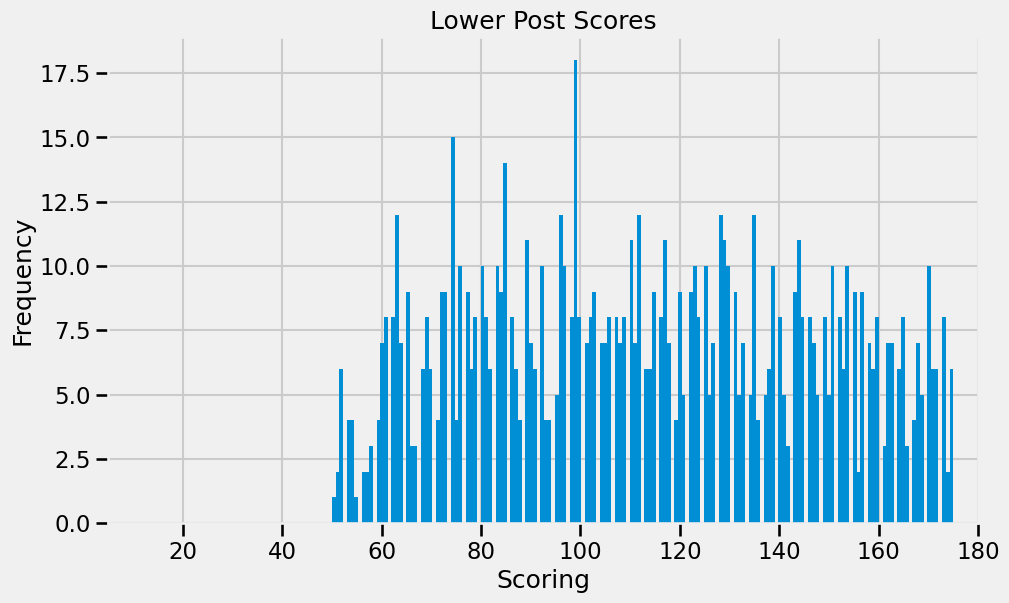

In [122]:
# Create the correct bin size
bins, lower, upper = binSize(lower=0, upper=175)

# Plot distribution of lower scores
tmp = df[[ True if lower <= x <= upper else False for x in df['score'] ]]['score']
plotHist(tmp=tmp, bins=bins, title='Lower Post Scores', xlabel='Scoring', ylabel='Frequency', l=5, u=5);

Lower Bound: 0
Upper Bound: 300

Local Max Length: 300
Local Average Length: 52
Local Median Length: 38


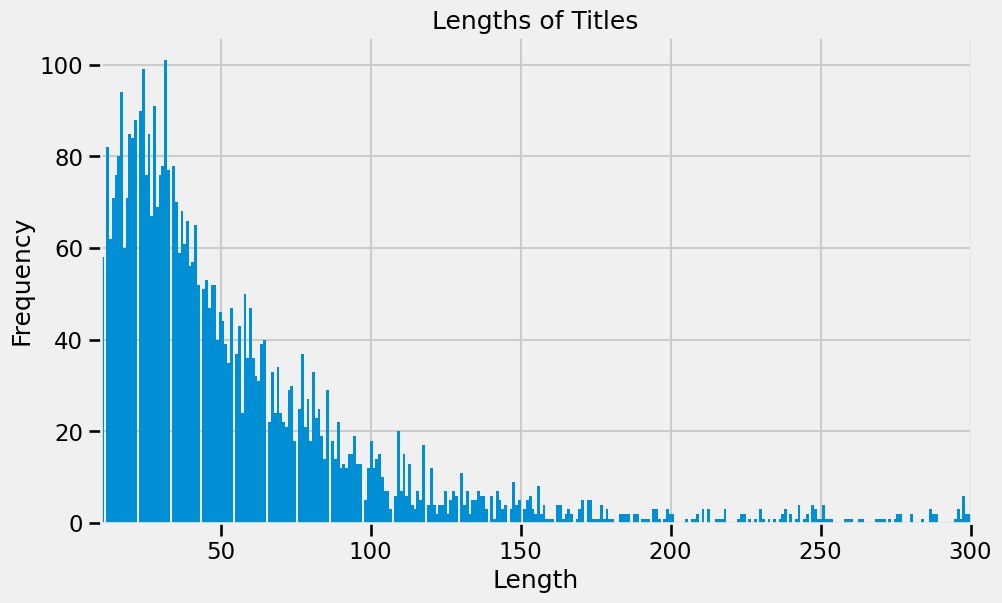

In [123]:
# Titles should be less than 300 charcters 
# Outliers are due to unicode translation
# Plot lengths of titles
tmp = [ len(x) for x in df.title ]
bins, lower, upper = binSize(lower=0, upper=300, buffer=-.09)

plotHist(tmp=tmp, bins=bins, title='Lengths of Titles', xlabel='Length', ylabel='Frequency', l=10, u=0);

Lower Bound: 500
Upper Bound: 5000

Local Max Length: 4926
Local Average Length: 1462
Local Median Length: 1098


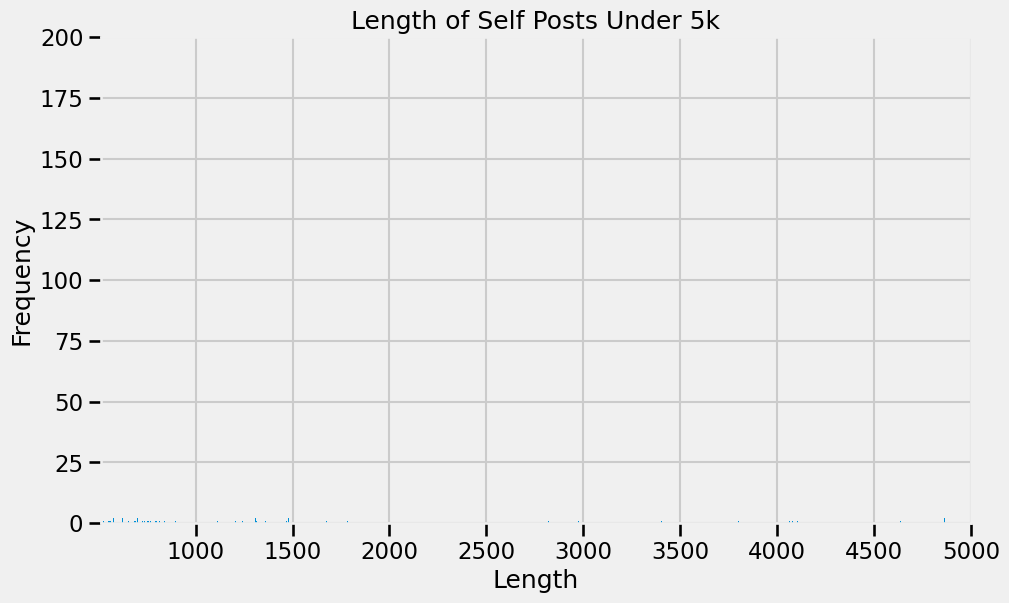

In [124]:
# Slice lengths of texts and plot histogram
bins, lower, upper = binSize(lower=500, upper=5000, buffer=.011)
tmp = [len(x) for x in df.selftext if lower <= len(x) <= upper]

plotHist(tmp=tmp, bins=bins, title='Length of Self Posts Under 5k', xlabel='Length', ylabel='Frequency', l=10, u=0)
plt.ylim(0, 200);

# Anomalies could be attributed to bots or duplicate reposts

Subreddits: 12
Total Posts: 28430
Total Posts from Top 100: 28430 , 1.000 of Total
Total Posts from Top 10: 28423 , 1.000 of Total

Top 10 Contributors: id              4567
url             4540
title           4477
created_utc     4426
author          4279
score           2229
subreddit       2122
selftext         761
num_comments     582
domain           440
dtype: int64


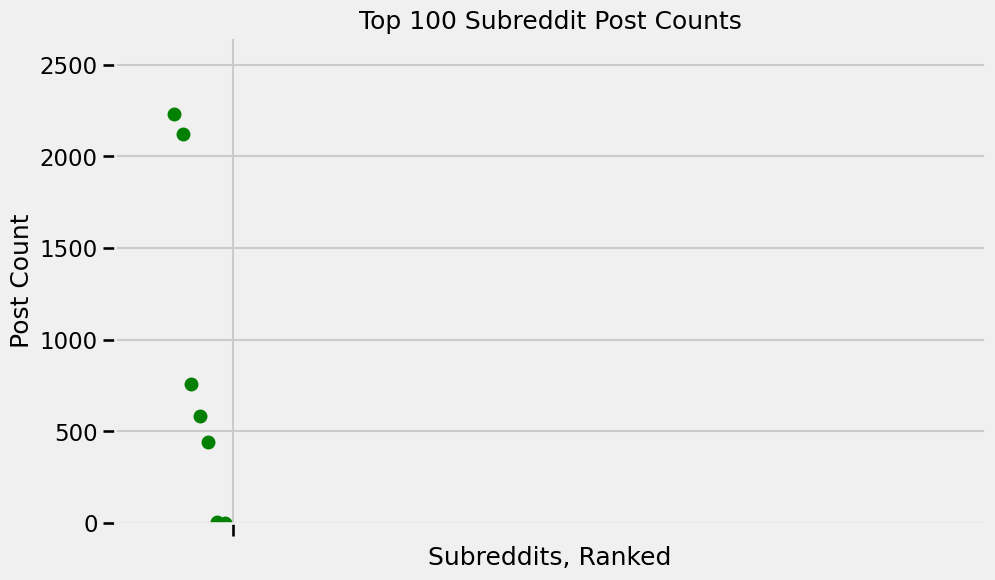

In [125]:
# Posts per Subreddit
# tmp = df.groupby('subreddit').nunique().sort_values(ascending=False)
# tmp = df.groupby('subreddit')['id'].nunique().sort_values(ascending=False)
tmp = df.nunique().sort_values(ascending=False)
top = 100
s = sum(tmp)
print('Subreddits:', len(tmp))
print('Total Posts:', s)
print('Total Posts from Top %s:' % top, sum(tmp[:top]), ', %.3f of Total' % (sum(tmp[:top])/s))
print('Total Posts from Top 10:', sum(tmp[:10]), ', %.3f of Total' % (sum(tmp[:10])/s))
print('\nTop 10 Contributors:', tmp[:10])



plt.figure(figsize=(10,6))
plt.plot(tmp, 'go')
plt.xticks('')
plt.title('Top %s Subreddit Post Counts' % top)
plt.xlabel('Subreddits, Ranked')
plt.ylabel('Post Count')    
plt.xlim(-2, top+1)
plt.ylim(0, 2650);

In [126]:
path1 = os.getcwd()+'/data/origin.pkl'
#path2 = os.getcwd()+'/data/grouped.pkl'

# Save important data
origin_df = df.loc[:,['created_utc', 'subreddit', 'author', 'title', 'selftext', 'id']] \
              .copy().reset_index().rename(columns={"index": "position"})
print(origin_df.info())
origin_df.to_pickle(path1)

posts_df = origin_df.loc[:,['title', 'selftext']]
posts_df['text'] = posts_df.title + ' ' + df.selftext
#del origin_df

# To group the results later
def groupUserPosts(x):
    ''' Group users' id's by post '''
    return pd.Series(dict(ids = ", ".join(x['id']),                    
                          text = ", ".join(x['text'])))

###df = posts_df.groupby('author').apply(groupUserPosts) 
#df.to_pickle(path2)

df = posts_df.text.to_frame()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     5000 non-null   int64  
 1   created_utc  5000 non-null   float64
 2   subreddit    5000 non-null   object 
 3   author       4999 non-null   object 
 4   title        5000 non-null   object 
 5   selftext     5000 non-null   object 
 6   id           5000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 273.6+ KB
None


In [127]:
origin_df.sample(2).drop('author', axis=1)

,position,created_utc,subreddit,title,selftext,id
3319,3319,1684762994.000,RocketLeague,The greatest ending to a 3v3 match,,13orbfu
2456,2456,1684831013.000,okkolegauposledzony,jeż(muj pies),,13pijfv


In [128]:
%%time
def clean_text(df, text_field):
    '''
    Clean all the text data within a certain text column of the dataFrame.
    '''
    df[text_field] = df[text_field].str.replace(r"http\S+", " ")
    df[text_field] = df[text_field].str.replace(r"&[a-z]{2,4};", "")
    df[text_field] = df[text_field].str.replace("\\n", " ")
    df[text_field] = df[text_field].str.replace(r"#f", "")
    df[text_field] = df[text_field].str.replace(r"[\’\'\`\":]", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
    df[text_field] = df[text_field].str.replace(r" +", " ")
    df[text_field] = df[text_field].str.lower()
    
clean_text(df, 'text')

CPU times: total: 78.1 ms
Wall time: 135 ms


In [129]:
df.sample(3)

,text
3910,"worst hr player | kalmah - swamphell [possession] (mazzerin, 7.42*) 98.94% 2485/2540 1xmiss #1 ..."
1141,squad i broke sisyphus
1466,ol’ billy fashionista


In [130]:
# For exploration of users
df[origin_df.author == '<Redacted>'][:3]

# User is a post summarizer and aggregator, added /r/tldr to the blocked list!

,text


Lower Bound: 500
Upper Bound: 5000

Local Max Lengths: 4967
Local Average Lengths: 1452
Local Median Lengths: 1098


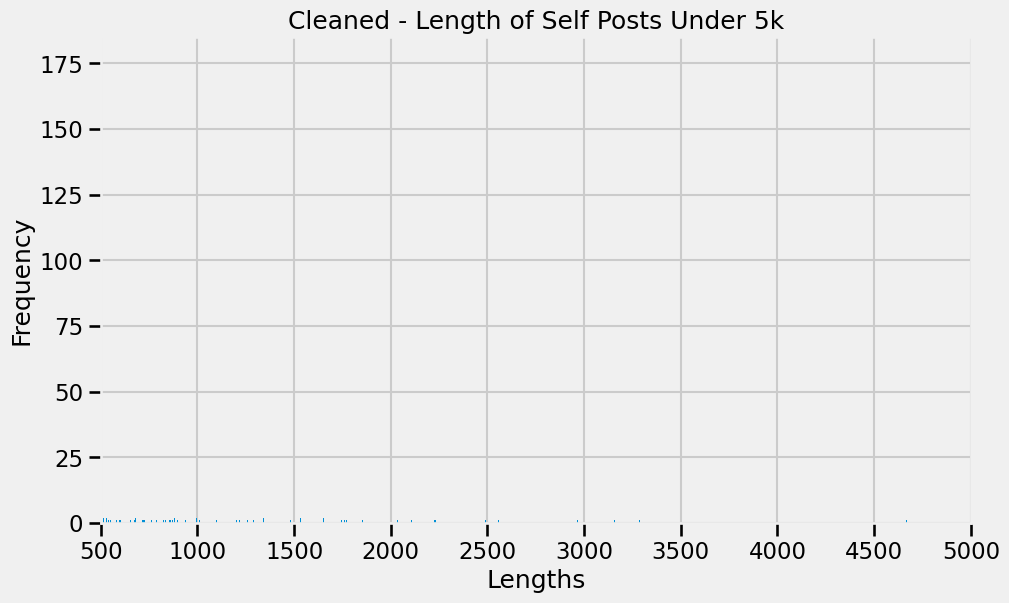

In [131]:
# Slice lengths of texts and plot histogram
bins, lower, upper = binSize(lower=500, upper=5000, buffer=.015)
tmp = [len(x) for x in df.text if lower <= len(x) <= upper]

plotHist(tmp=tmp, bins=bins, title='Cleaned - Length of Self Posts Under 5k', 
         xlabel='Lengths', ylabel='Frequency', l=0, u=0)
plt.ylim(0, 185);

In [132]:
# Download everything for nltk! ('all')
import nltk
# nltk.download() # (Change config save path)
nltk.data.path.append('/home/User/data/')

In [133]:
from nltk.corpus import stopwords

# "stopeng" is our extended list of stopwords for use in the CountVectorizer
# I could spend days extending this list for fine tuning results
stopeng = stopwords.words('english')
stopeng.extend([x.replace("\'", "") for x in stopeng])
stopeng.extend(['nbsp', 'also', 'really', 'ive', 'even', 'jon', 'lot', 'could', 'many'])
stopeng = list(set(stopeng))

In [134]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count vectorization for LDA
cv = CountVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                     stop_words=stopeng, ngram_range=(1,1), lowercase=False,
                     dtype='uint8')

# Vectorizer object to generate term frequency-inverse document frequency matrix
tfidf = TfidfVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                        stop_words=stopeng, ngram_range=(1,1), lowercase=False,
                        sublinear_tf=True, smooth_idf=False, dtype='float32')

###### Tokenization is one of the most important steps in NLP, I will explain some of my parameter choices in the README. CountVectorizer was my preferred choice. I used these definitions to help me in the iterative process of building an unsupervised model.

###### The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

###### Smooth = False: The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored.

###### sublinear_tf = True: “l” (logarithmic), replaces tf with 1 + log(tf)

In [135]:
%%time
# Count & tf-idf vectorizer fits the tokenizer and transforms data into new matrix
cv_vecs = cv.fit_transform(df.text).transpose()
tf_vecs = tfidf.fit_transform(df.text).transpose()
pickle.dump(cv_vecs, open(os.getcwd()+'/data/cv_vecs.pkl', 'wb'))

# Checking the shape and size of the count vectorizer transformed matrix
# 47,317 terms
# 146996 documents
print("Sparse Shape:", cv_vecs.shape) 
print('CV:', sys.getsizeof(cv_vecs))
print('Tf-Idf:', sys.getsizeof(tf_vecs))

Sparse Shape: (17797, 5000)
CV: 48
Tf-Idf: 48
CPU times: total: 266 ms
Wall time: 570 ms


In [136]:
# IFF using a subset can you store these in a Pandas DataFrame/

#tfidf_df = pd.DataFrame(tf_vecs.transpose().todense(), columns=[tfidf.get_feature_names()]).astype('float32')
#cv_df = pd.DataFrame(cv_vecs.transpose().todense(), columns=[cv.get_feature_names()]).astype('uint8')

#print(cv_df.info())
#print(tfidf_df.info())

In [137]:
#cv_description = cv_df.describe().T
#tfidf_description = tfidf_df.describe().T

#tfidf_df.sum().sort_values(ascending=False)

In [138]:
# Explore the document-term vectors
#cv_description.sort_values(by='max', ascending=False)
#tfidf_description.sort_values(by='mean', ascending=False)

## Singular Value Decomposition (SVD)

## <a id='lda'></a> Latent Dirichlet Allocation (LDA)

In [139]:
%%time
run = False

passes = 85
if run==True:
    lda = models.LdaMulticore(corpus=cv_corpus, num_topics=15, id2word=id2word, passes=passes, 
                              workers=13, random_state=42, eval_every=None, chunksize=6000)

CPU times: total: 0 ns
Wall time: 0 ns


In [140]:
# Save model after your last run, or continue to update LDA
#pickle.dump(lda, open(os.getcwd()+'/data/lda_gensim.pkl', 'wb'))

# Gensim save
#lda.save(os.getcwd()+'/data/gensim_lda.model')
lda =  models.LdaModel.load(os.getcwd()+'/data/gensim_lda.model')

2023-05-26 17:35:39,597 : INFO : loading LdaModel object from d:\QC supplements\Code\Apps\Reddit trend analysis\NLP-Reddit/data/gensim_lda.model
2023-05-26 17:35:39,615 : INFO : loading expElogbeta from d:\QC supplements\Code\Apps\Reddit trend analysis\NLP-Reddit/data/gensim_lda.model.expElogbeta.npy with mmap=None
2023-05-26 17:35:39,624 : INFO : setting ignored attribute state to None
2023-05-26 17:35:39,629 : INFO : setting ignored attribute id2word to None
2023-05-26 17:35:39,631 : INFO : setting ignored attribute dispatcher to None
2023-05-26 17:35:39,633 : INFO : LdaMulticore lifecycle event {'fname': 'd:\\QC supplements\\Code\\Apps\\Reddit trend analysis\\NLP-Reddit/data/gensim_lda.model', 'datetime': '2023-05-26T17:35:39.633985', 'gensim': '4.3.1', 'python': '3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}
2023-05-26 17:35:39,636 : INFO : loading LdaState object from d

In [141]:
%%time
cv_corpus = pickle.load(open(os.getcwd()+'/data/cv_corpus.pkl','rb'))

# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[cv_corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

CPU times: total: 1.67 s
Wall time: 3.01 s


In [142]:
# Review Dirichlet distribution for documents
lda_docs[4999]
# lda_docs[25000]

[(0, 0.03372076),
 (1, 0.03372076),
 (2, 0.03372077),
 (3, 0.03372076),
 (4, 0.03372076),
 (5, 0.03372076),
 (6, 0.03372076),
 (7, 0.03372076),
 (8, 0.03372076),
 (9, 0.03372076),
 (10, 0.03372076),
 (11, 0.03372076),
 (12, 0.03372076),
 (13, 0.03372076),
 (14, 0.52790934)]

In [143]:
# Manually review the document to see if it makes sense! 
# Look back at the topics that it matches with to confirm the result!
df.iloc[4999]

text    to escape  
Name: 4999, dtype: object

In [144]:
#bow = df.iloc[1,0].split()

# Print topic probability distribution for a document
#print(lda[bow]) #Values unpack error

# Given a chunk of sparse document vectors, estimate gamma:
# (parameters controlling the topic weights) for each document in the chunk.
#lda.inference(bow) #Not enough values

# Makeup of each topic! Interpretable! 
# The d3 visualization below is far better for looking at the interpretations.
lda.print_topics(num_words=10, num_topics=1)

2023-05-26 17:35:43,273 : INFO : topic #4 (0.067): 0.004*"world" + 0.003*"women" + 0.003*"men" + 0.003*"believe" + 0.003*"may" + 0.002*"war" + 0.002*"think" + 0.002*"country" + 0.002*"state" + 0.002*"government"


[(4,
  '0.004*"world" + 0.003*"women" + 0.003*"men" + 0.003*"believe" + 0.003*"may" + 0.002*"war" + 0.002*"think" + 0.002*"country" + 0.002*"state" + 0.002*"government"')]

## <a id='py'></a> pyLDAvis

In [145]:
# For quickstart, we can just jump straight to results

def loadingPickles():
    id2word = pickle.load(open(os.getcwd()+'/data/id2word.pkl','rb'))
    cv_vecs = pickle.load(open(os.getcwd()+'/data/cv_vecs.pkl','rb'))
    cv_corpus = pickle.load(open(os.getcwd()+'/data/cv_corpus.pkl','rb'))
    lda =  models.LdaModel.load(os.getcwd()+'/data/gensim_lda.model')
    return id2word, cv_vecs, cv_corpus, lda

In [146]:
import pyLDAvis.gensim
import gensim

# Enables visualization in jupyter notebook
pyLDAvis.enable_notebook()

# Prepare the visualization
# Change multidimensional scaling function via mds parameter
# Options are tsne, mmds, pcoa 
# cv_corpus or cv_vecs work equally
id2word, _, cv_corpus, lda = loadingPickles()
viz = pyLDAvis.gensim.prepare(topic_model=lda, corpus=cv_corpus, dictionary=id2word, mds='mmds')

# Save the html for sharing!
pyLDAvis.save_html(viz,os.getcwd()+'/data/viz.html')

# Interact! Saliency is the most important metric that changes the story of each topic.
pyLDAvis.display(viz)

2023-05-26 17:35:43,698 : INFO : loading LdaModel object from d:\QC supplements\Code\Apps\Reddit trend analysis\NLP-Reddit/data/gensim_lda.model
2023-05-26 17:35:43,707 : INFO : loading expElogbeta from d:\QC supplements\Code\Apps\Reddit trend analysis\NLP-Reddit/data/gensim_lda.model.expElogbeta.npy with mmap=None
2023-05-26 17:35:43,714 : INFO : setting ignored attribute state to None
2023-05-26 17:35:43,715 : INFO : setting ignored attribute id2word to None
2023-05-26 17:35:43,717 : INFO : setting ignored attribute dispatcher to None
2023-05-26 17:35:43,719 : INFO : LdaMulticore lifecycle event {'fname': 'd:\\QC supplements\\Code\\Apps\\Reddit trend analysis\\NLP-Reddit/data/gensim_lda.model', 'datetime': '2023-05-26T17:35:43.719180', 'gensim': '4.3.1', 'python': '3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}
2023-05-26 17:35:43,721 : INFO : loading LdaState object from d

# There you have it. There is a ton of great information right here that I will conclude upon in the README and the slides on my github. 

###### In it I will discuss what I could do with this information. I did not end up using groupUserPosts but I could create user profiles based on the aggregate of their document topic distributions. I believe this is a great start to understanding NLP and how it can be used. I would consider working on this again but with more technologies needed for big data.